In [1]:
import lmfit
from quantify_core.analysis.fitting_models import fft_freq_phase_guess

# Cosine function that is fit to Rabi oscillations
def cos_func(
    drive_amp: float,
    frequency: float,
    amplitude: float,
    offset: float,
    phase: float = 0,
) -> float:
    return amplitude * np.cos(2 * np.pi * frequency * (drive_amp + phase)) + offset

class ChevronModel(lmfit.model.Model):
    """
    Generate a cosine model that can be fit to Rabi oscillation data.
    """
    def __init__(self, *args, **kwargs):
        # Pass in the defining equation so the user doesn't have to later.
        super().__init__(cos_func, *args, **kwargs)

        # Enforce oscillation frequency is positive
        self.set_param_hint("frequency", min=0)

        # Fix the phase at pi so that the ouput is at a minimum when drive_amp=0
        self.set_param_hint("phase", min = -0.5, max = 0.5)

        # Pi-pulse amplitude can be derived from the oscillation frequency
        self.set_param_hint("swap", expr="1/(2*frequency)-phase", vary=False)
        self.set_param_hint("cz", expr="2/(2*frequency)-phase", vary=False)


    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        drive_amp = kws.get("drive_amp", None)
        if drive_amp is None:
            return None

        amp_guess = abs(max(data) - min(data)) / 2  # amp is positive by convention
        offs_guess = np.mean(data)

        # Frequency guess is obtained using a fast fourier transform (FFT).
        (freq_guess, _) = fft_freq_phase_guess(data, drive_amp)

        self.set_param_hint("frequency", value=freq_guess, min=0)
        self.set_param_hint("amplitude", value=amp_guess, min=0)
        self.set_param_hint("offset", value=offs_guess)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
dp = r'data_directory/20231108/20231108-165449-319-ec0bc2-cz_chevron/dataset.hdf5'
ds = load_dataset(dp)

In [3]:
qubit = 'q22'
freq = ds[f'cz_pulse_frequencies_sweep{qubit}'].values/1e6
amp = ds[f'cz_pulse_amplitudes{qubit}'].values
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
magnitudes = (magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes))

In [4]:
fit_results = []
for magnitude in magnitudes:
    model = ChevronModel()
    # magnitude = np.transpose(values)[15]
    fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
    guess = model.guess(magnitude, drive_amp=amp)
    fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
    fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
    fit_results.append(fit_result)
    # plt.plot(y,magnitude,'.r')
    # plt.plot(fit_amplitudes,fit_y,'--b')
qois = np.transpose([[fit.result.params[p].value for p in ['amplitude','frequency']] for fit in fit_results])
qois = np.transpose([(q-np.min(q))/np.max(q) for q in qois])
opt_id = np.argmax(np.sum(qois,axis=1))
opt_freq = freq[opt_id]
opt_cz = fit_results[opt_id].result.params['cz'].value
opt_swap = fit_results[opt_id].result.params['swap'].value
opt_id,opt_freq,opt_cz,opt_swap

(2, 230.0, 0.04504371456600402, 0.029663359163240737)

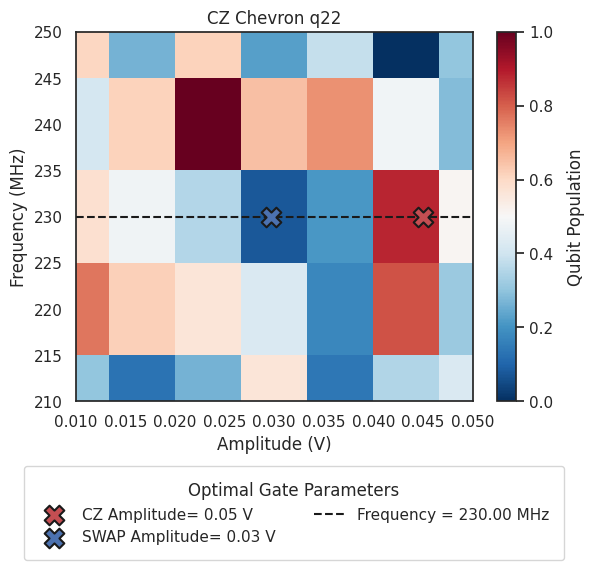

In [5]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
# plt.figure(figsize=(10,6))
fig = plt.pcolormesh(amp,freq,magnitudes,shading='nearest',cmap='RdBu_r')
plt.scatter(opt_cz,opt_freq,c='r',label = 'CZ Amplitude= {:.2f} V'.format(opt_cz),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP Amplitude= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
plt.hlines(opt_freq,amp[0],amp[-1],label = 'Frequency = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
plt.legend(loc = 'lower center', bbox_to_anchor=(-0.15, -0.45, 1.4, .102), mode='expand', ncol=2,
            title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
#                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
cbar = plt.colorbar(fig)
cbar.set_label('Qubit Population', labelpad=10)
plt.ylim([freq[0],freq[-1]])
plt.xlim([amp[0],amp[-1]])
plt.xlabel('Amplitude (V)')
plt.ylabel('Frequency (MHz)')
plt.title(f'CZ Chevron {qubit}')
plt.show()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude    0.1728        0      inf  0.05918     True     None     None
cz           0.0278     -inf      inf 0.001193    False 2/(2*frequency)-phase     None
frequency     47.85        0      inf    4.476     True     None     None
offset        0.294     -inf      inf   0.0436     True     None     None
phase      -0.006898     -0.5      0.5 0.002432     True     None     None
swap        0.01735     -inf      inf 0.001647    False 1/(2*frequency)-phase     None


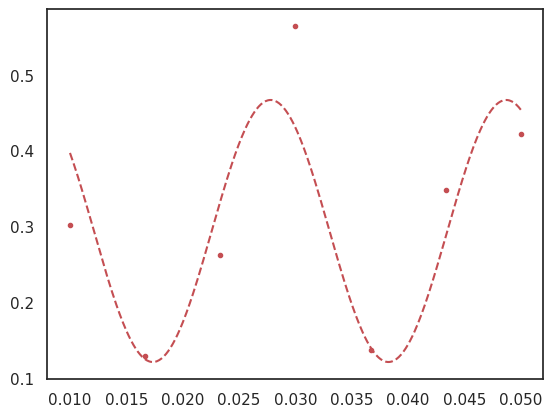

In [13]:
model = ChevronModel()
magnitude = magnitudes[0]
fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
guess = model.guess(magnitude, drive_amp=amp)
fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
fit_result.params.pretty_print()
plt.plot(amp,magnitude,'.r')
plt.plot(fit_amplitudes,fit_y,'--r')